In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.model_selection import GridSearchCV,train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score,make_scorer
from scipy.stats import norm, skew
from scipy import stats
import os
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression,Perceptron,SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [221]:
train_df = pd.read_csv(os.path.join(os.getcwd(),'data/train.csv'))
test_df = pd.read_csv(os.path.join(os.getcwd(),'data/test.csv'))

In [222]:
combine = [train_df,test_df]

In [4]:
## Missing Value for train_df
## Cabin has 77% missing value, should be dropped 
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_value= pd.concat([total,percent],keys=['total','percent'],axis=1)
missing_value[missing_value.total>0]

,total,percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245


In [5]:
## Missing value for test_df
## cabin should be dropped 
total = test_df.isnull().sum().sort_values(ascending=False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending=False)
missing_value= pd.concat([total,percent],keys=['total','percent'],axis=1)
missing_value[missing_value.total>0]

,total,percent
Cabin,327,0.782297
Age,86,0.205742
Fare,1,0.002392


In [6]:
## Ticket has a high ratio (24%) of duplicates( unique = 681, total = 891)
## Male dominated the sex (64%)

print('*'*100)

train_df.describe(include='object')

****************************************************************************************************


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Padro y Manent, Mr. Julian",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [311]:
## Pclass 1 has the highest avg. survival rate 
train_df.groupby(['Pclass'],as_index=False).mean()[['Pclass','Survived']].sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [312]:
print('*'*100)
pd.crosstab(train_df.Pclass,train_df.Survived)

****************************************************************************************************


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [313]:
## Female has much higher survival rate, but considering majority of passengers were male
train_df.groupby(['Sex']).mean()['Survived'].sort_values(ascending=False)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

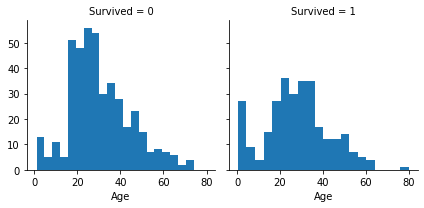

In [10]:
## large number of people aged from 15-35 didn't survive 
## Infants (aged less than 5) had high survial rate
## Older people ( age=80) survived

g = sns.FacetGrid(train_df,col='Survived')
g.map(plt.hist,'Age',bins=20)

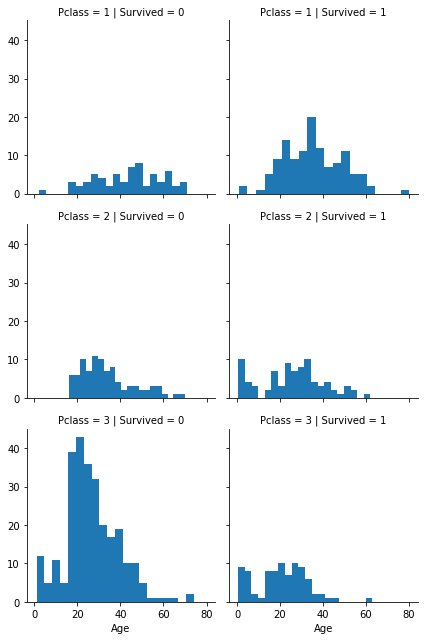

In [87]:
g= sns.FacetGrid(train_df,col='Survived',row='Pclass')
g.map(plt.hist,'Age',bins=20)


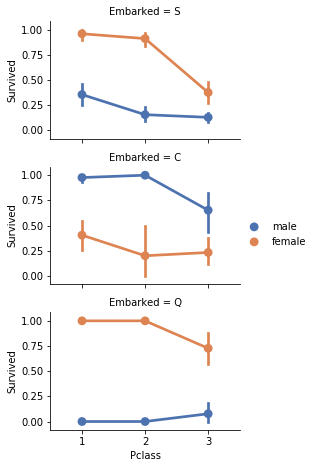

In [96]:
g= sns.FacetGrid(train_df,row='Embarked',size=2.2,aspect=1.6)
g.map(sns.pointplot,'Pclass','Survived','Sex',palette='deep')
g.add_legend()

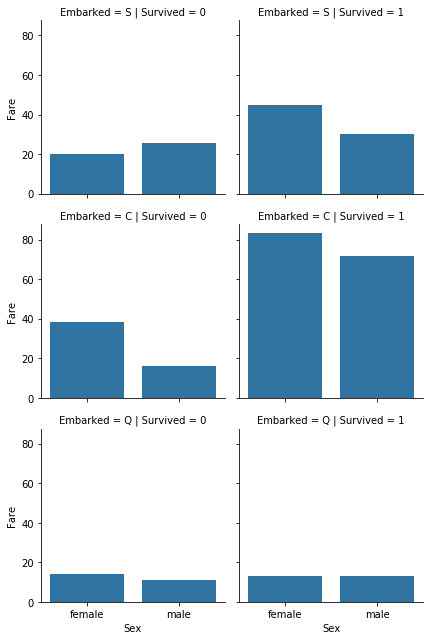

In [21]:
g=sns.FacetGrid(train_df,col='Survived',row='Embarked')
g.map(sns.barplot,'Sex','Fare',ci=None)
g.add_legend()

## Feature Engineering

In [226]:
## Drop features of Cabin and Ticket
train_df=train_df.drop(['Ticket','Cabin'],axis=1)
test_df =test_df.drop(['Ticket','Cabin'],axis=1)
combine=[train_df,test_df]

In [223]:
##Create new feature by extracting Title from Name 
for dataset in combine:
    dataset['Title']=dataset.Name.str.extract('([A-Za-z]+)\.',expand=False)

## Unify Title grouping
for dataset in combine:
    dataset['Title']=dataset['Title'].replace(['Countess','Lady','Capt','Col','Don','Dona','Dr','Jonkheer','Major','Rev','Sir'],'Rare')
    dataset['Title']=dataset['Title'].replace(['Mlle','Ms'],'Miss')
    dataset['Title']=dataset['Title'].replace({'Mme':'Mrs'})

### Convert Title to ordinal 
for dataset in combine:
    dataset['Title']=dataset['Title'].replace({'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5})

## Convert Sex to binary Female :1 Male:0
# train_df['Sex']=np.where(train_df.Sex.str.contains('female'),1,0)
# test_df['Sex']=np.where(test_df.Sex.str.contains('female'),1,0)
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].replace( {'female': 1, 'male': 0} ).astype(int)

In [227]:
## Drop Name for train_df,test_df, drop PassengerId for train_df
train_df=train_df.drop(['Name','PassengerId'],axis=1)
test_df=test_df.drop(['Name'],axis=1)
combine = [train_df,test_df]

In [228]:
## Fillna for Age by using combination of Sex and Pclass
guessed_age= np.zeros((2,3))
for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            guess_df = dataset[(dataset['Sex']==i)& (dataset['Pclass']==j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guessed_age[i,j]=int(age_guess)
    
    for i in range(0,2):
        for j in range(0,3):
            dataset.loc[(dataset.Age.isnull())&(dataset.Sex==i)&(dataset.Pclass==j+1),'Age']=guessed_age[i,j]

In [229]:
## Turn continuous numerical values to bands and turn it into ordinal 
train_df['Ageband']=pd.cut(train_df.Age,5)
combine = [train_df,test_df]
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32),'Age']=1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48),'Age']=2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64),'Age']=3
    dataset.loc[dataset['Age']>64,'Age']=4
train_df = train_df.drop('Ageband',axis=1)
combine=[train_df,test_df]

In [230]:
## Combine existing features and create new feature: IsAlone
for dataset in combine:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
for dataset in combine:
    dataset['IsAlone']=0
    dataset.loc[dataset.FamilySize==1,'IsAlone']=1

train_df= train_df.drop(['Parch', 'SibSp', 'FamilySize'],axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'],axis=1)
combine=[train_df,test_df]

In [231]:
for dataset in combine: 
    dataset['Age*Class']=dataset.Age * dataset.Pclass

In [232]:
print('*'*100)
train_df.Embarked.mode()[0]
for dataset in combine:
    dataset.loc[:,'Embarked']=dataset.loc[:,'Embarked'].fillna(train_df.Embarked.mode()[0])
for dataset in combine:
    dataset['Embarked']=dataset['Embarked'].replace({'S':0,'C': 1, 'Q': 2})

****************************************************************************************************


In [233]:
test_df['Fare'].fillna(test_df.Fare.median(),inplace=True)

In [234]:
train_df['FareBand']=pd.qcut(train_df.Fare,4)
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

train_df= train_df.drop(['FareBand'],axis=1)
combine=[train_df,test_df]

## Modelling

In [389]:
def rmse_cv_train(model):
    RMSE = np.sqrt(-cross_val_score(model,X_train,y_train,scoring='neg_mean_squared_error',cv=10))
    return RMSE

In [235]:
X_train=train_df.drop('Survived',axis=1)
y_train=train_df.Survived.values
X_test = test_df.drop('PassengerId',axis=1).copy()

In [344]:
## LogisticRegression

logreg= LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [429]:
accuracy_log=logreg.score(X_train,y_train)

In [419]:
RMSE_log=rmse_cv_train(logreg).mean()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

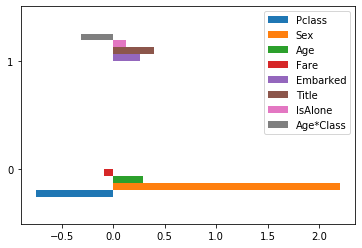

In [351]:
coefs= pd.Series(logreg.coef_[0],index=X_train.columns)
img =pd.DataFrame([coefs.head(4),coefs.tail(4)])
## Sex is the highest positive coef, implying as the Sex value increases( from Male 0 to Female 1)
## The probability of svrvived =1 increases the most

## Inversely as Pclass increases, the probability of survived =1 decreases the most
img.plot(kind='barh')

In [383]:
## Support Vector Machine
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [384]:
accuracy_svc=round(svc.score(X_train,y_train),4)

In [420]:
RMSE_svc=rmse_cv_train(svc).mean()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

In [377]:
## KNN
knn= KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [386]:
accuracy_knn=round(knn.score(X_train,y_train),4)

In [421]:
RMSE_knn=rmse_cv_train(knn).mean()

In [396]:
## Gaussian Naive Bayes
gaussian= GaussianNB()
gaussian.fit(X_train,y_train)
y_pred=gaussian.predict(X_test)

GaussianNB(priors=None, var_smoothing=1e-09)

In [400]:
accuracy_gaussian=gaussian.score(X_train,y_train)

In [422]:
RMSE_gaussian=rmse_cv_train(gaussian).mean()

In [403]:
## Decision Tree


tree= DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [407]:
accuracy_tree=tree.score(X_train,y_train)

In [423]:
RMSE_tree=rmse_cv_train(tree).mean()

In [411]:
## Random Forest

random_forest=RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,y_train)
y_pred=random_forest.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [414]:
acc_random_forest=random_forest.score(X_train,y_train)

In [424]:
RMSE_random=rmse_cv_train(random_forest).mean()

In [430]:
models= pd.DataFrame({'Model':['Logistic Regression','Support Vector Machine','KNN','Naive Bayes','Decision Tree','Random Forest'],
             'Score':[accuracy_log,accuracy_svc,accuracy_knn,accuracy_gaussian,accuracy_tree,acc_random_forest],
              'RMSE':[RMSE_log,RMSE_svc,RMSE_knn,RMSE_gaussian,RMSE_tree,RMSE_random]
             
             
             })
models.sort_values(by='Score',ascending=False)

,Model,Score,RMSE
4,Decision Tree,0.867565,0.444387
5,Random Forest,0.867565,0.437328
2,KNN,0.842900,0.442934
1,Support Vector Machine,0.837300,0.418932
0,Logistic Regression,0.803591,0.441670
3,Naive Bayes,0.722783,0.535101


In [433]:
prediction=pd.DataFrame({'PassengerId':test_df['PassengerId'],'Survived':y_pred})

In [18]:
print('*' *100)

****************************************************************************************************


## Hyperparameters Tuning 

In [12]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

train_df=transform_features(train_df)
test_df=transform_features(test_df)

In [13]:
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
train_df,test_df = encode_features(train_df,test_df)

In [14]:
train=train_df.drop(['PassengerId','Survived'],axis=1)
y = train_df['Survived'].values
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size=0.2,random_state=23)

In [7]:
pipeline = make_pipeline(StandardScaler(),RandomForestClassifier())

In [8]:
hyperparameters={'randomforestclassifier__n_estimators':[4,6,9],
                'randomforestclassifier__max_features': ['log2','sqrt','auto'],
               'randomforestclassifier__criterion':['entropy','gini'],
    'randomforestclassifier__max_depth':[2,3,5,10],
    'randomforestclassifier__min_samples_split':[2,3,5],
     'randomforestclassifier__min_samples_leaf':[1,5,8] }
acc_score= make_scorer(accuracy_score)
clf =GridSearchCV(pipeline,hyperparameters,scoring=acc_score)

In [9]:
clf.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_

In [10]:
clf.best_params_

{'randomforestclassifier__criterion': 'entropy',
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 3,
 'randomforestclassifier__n_estimators': 9}

In [11]:
clf.refit
y_pred=clf.predict(X_test)

In [12]:
accuracy_score(y_test,y_pred)

0.8379888268156425

In [120]:
def run_kfold(clf):
    kf=KFold(n_splits=10)
    fold=0
    outcome=[]
    for train_index,test_index in kf.split(train):
        fold+=1
        X_train,X_test= train.values[train_index],train.values[test_index]
        y_train,y_test = y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        accuracy=accuracy_score(y_test,y_pred)
        outcome.append(accuracy)
        print('Fold{} accuracy:{}'.format(fold,accuracy))
    mean_outcome = np.mean(outcome)
    print('Mean Accuray:{}'.format(mean_outcome))

In [121]:
run_kfold(clf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold1 accuracy:0.8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold2 accuracy:0.8202247191011236


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold3 accuracy:0.8089887640449438


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold4 accuracy:0.8426966292134831


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold5 accuracy:0.797752808988764


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold6 accuracy:0.8202247191011236


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold7 accuracy:0.7865168539325843


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold8 accuracy:0.7752808988764045


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold9 accuracy:0.898876404494382


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold10 accuracy:0.8089887640449438
Mean Accuray:0.8159550561797753


In [123]:
predictions =clf.predict(test_df.drop(['PassengerId'],axis=1))

In [126]:
output =pd.DataFrame({'PassengerId':test_df['PassengerId'],'Predictions':predictions})
output.head()

,PassengerId,Predictions
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
def run_kfold(clf):
    kf=KFold(n_splits=10)
    fold=0
    outcome=[]
    for train_index,test_index in kf.split(train):
        fold+=1
        X_train,X_test=train.values[train_index],train.values[test_index]
        y_train,y_test=y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        acc_score=accuracy_score(y_test,y_pred)
        outcome.append(acc_score)
        print('Fold {} score is: {}'.format(fold,outcome))
    mean_outcome=np.mean(outcome)
    print('Mean score is :{}'.format(mean_outcome))

## XGBoost 

In [8]:
pipeline=make_pipeline(StandardScaler(),XGBClassifier(n_estimators=100))

In [17]:
hyperparameters={'xgbclassifier__gamma':[0,0.9,1],
               'xgbclassifier__learning_rate':[0.5,1] ,
'xgbclassifier__max_depth':[3,5]
                }

In [18]:
acc_score=make_scorer(accuracy_score)

In [19]:
clf=GridSearchCV(pipeline,hyperparameters,scoring=acc_score)

In [20]:
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
 

In [21]:
clf.best_params_

{'xgbclassifier__gamma': 0.9,
 'xgbclassifier__learning_rate': 0.5,
 'xgbclassifier__max_depth': 3}

In [35]:
def run_kf(clf):
    fold=0
    kf=KFold(n_splits=10)
    outcome=[]
    for train_index,test_index in kf.split(train):
        fold+=1
        X_train,X_test=train.values[train_index],train.values[test_index]
        y_train,y_test=y[train_index],y[test_index]
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        score=accuracy_score(y_test,y_pred)
        outcome.append(score)
        print('Fold{} accuracy is: {}'.format(fold,outcome))
    mean_accuracy=np.mean(outcome)
    print('Mean accuracy is : {}'.format(mean_accuracy))

In [36]:
run_kf(clf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold1 accuracy is: [0.8222222222222222]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold2 accuracy is: [0.8222222222222222, 0.8764044943820225]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold3 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold4 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold5 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold6 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236, 0.797752808988764]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold7 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236, 0.797752808988764, 0.7640449438202247]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold8 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236, 0.797752808988764, 0.7640449438202247, 0.7865168539325843]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold9 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236, 0.797752808988764, 0.7640449438202247, 0.7865168539325843, 0.8876404494382022]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fold10 accuracy is: [0.8222222222222222, 0.8764044943820225, 0.8089887640449438, 0.8314606741573034, 0.8202247191011236, 0.797752808988764, 0.7640449438202247, 0.7865168539325843, 0.8876404494382022, 0.7752808988764045]
Mean accuracy is : 0.8170536828963796


In [39]:
test = test_df.drop(['PassengerId'],axis=1)
y_pred=clf.predict(test)
result = pd.DataFrame({'PassengerId':test_df['PassengerId'],'Prediction':y_pred})

## Ensembling & Stacking Models

In [224]:
for dataset in combine:
    dataset['Has_Cabin']=dataset.Cabin.apply(lambda x:0 if type(x)==float else 1)

In [225]:
for dataset in combine:
    dataset['Name_length']=dataset.Name.apply(lambda x: len(x))

In [288]:
print('*'*100)

****************************************************************************************************


In [295]:
## Create Sklearn class to make codes scalable
class SklearnHelper(object):
    def __init__(self, clf, seed=0,params = None):
        params['random_state']=seed
        self.clf=clf(**params)
    def train(self,X_train,y_train):
        return self.clf.fit(X_train,y_train)
    def predict(self,X_test):
        return self.clf.predict(X_test)
    def fit(self,X_train,y_train):
        return self.clf.fit(X_train,y_train)
    def feature_importance(self,X_train,y_train):
         return self.clf.fit(X_train,y_train).feature_importances_

In [259]:
n_train=train_df.shape[0]
n_test=test_df.shape[0]
seed = 0
n_folds=5
kf=KFold(n_splits=n_folds,random_state=seed)
## Use KFold to split X_train to sub train models 
def get_oof(clf,X_train,y_train,X_test):
    oof_train=np.zeros((n_train,))
    oof_test=np.zeros((n_test,))
    oof_test_kf=np.empty((n_folds,n_test))
    
    for i,(train_index,test_index) in enumerate(kf.split(X_train)):
        x_tr,x_te = X_train.values[train_index],X_train.values[test_index]
        y_tr=y_train[train_index]
        clf.train(x_tr,y_tr)
        
        oof_train[test_index]=clf.predict(x_te)
        oof_test_kf[i,:] = clf.predict(X_test)
    oof_test[:] = oof_test_kf.mean(axis=0)
    return oof_train.reshape(-1,1),oof_test.reshape(-1,1)

In [296]:
rf_params={'n_jobs':-1,'n_estimators':500,'warm_start':True,
'max_depth':6,'min_samples_leaf':2,'max_features':'sqrt'}
et_params={'n_jobs':-1,'n_estimators':500,'max_depth':8,
 'min_samples_leaf':2         }
ada_params={ 'n_estimators':500,'learning_rate':0.75}
gb_params={'n_estimators':500,'max_depth':5, 'min_samples_leaf':2}
svc_params={'kernel':'linear','C':0.025}

In [297]:
rf=SklearnHelper(clf=RandomForestClassifier,seed=seed,params=rf_params)
et=SklearnHelper(clf=ExtraTreesClassifier,seed=seed,params=et_params)
ada=SklearnHelper(clf=AdaBoostClassifier,seed=seed,params=ada_params)
gb=SklearnHelper(clf=GradientBoostingClassifier,seed=seed,params=gb_params)
svc=SklearnHelper(clf=SVC,seed=seed,params=svc_params)

In [262]:
et_oof_train,et_oof_test=get_oof(rf,X_train,y_train,X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,X_train, y_train, X_test) # Support Vector Machine

In [ ]:
rf.feature_importance(X_train,y_train)
et.feature_importance(X_train,y_train)
ada.feature_importance(X_train,y_train)
gb.feature_importance(X_train,y_train)


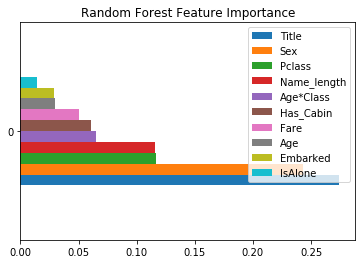

In [318]:
rf_features=[0.11656542, 0.2429004 , 0.02974277, 0.05079856 ,0.0286916 , 0.2743337,
 0.06107318, 0.11613319 ,0.01459769, 0.06516348]

et_features=[0.13287748, 0.36248607 ,0.02733573 ,0.05851281, 0.03354825, 0.18935198,
 0.08346825, 0.05052766 ,0.02433916, 0.03755263]

ada_features=[0.05 , 0.012, 0.02 , 0.044 ,0.012, 0.048, 0.014 ,0.712, 0.006, 0.082]

gb_features=[0.11318049 ,0.01103442, 0.03104292, 0.08126349 ,0.03372682 ,0.44356943,
 0.04388375, 0.19125237, 0.01910655 ,0.03193977]



rf_features=pd.Series(rf.feature_importance(X_train,y_train),index=X_train.columns).sort_values(ascending=False)
et_features=pd.Series(et.feature_importance(X_train,y_train),index=X_train.columns).sort_values(ascending=False)
ada_features=pd.Series(ada.feature_importance(X_train,y_train),index=X_train.columns).sort_values(ascending=False)
gb_features=pd.Series(gb.feature_importance(X_train,y_train),index=X_train.columns).sort_values(ascending=False)
img=pd.DataFrame([rf_features.tail(10)])
img.plot(kind='barh',title='Random Forest Feature Importance')

In [302]:
feature_df=pd.DataFrame({'col':X_train.columns.values,'Random Forest Feature Importance':rf_features,'Extra Trees Feature Importance':et_features,'AdaBoost Feature Importance':ada_features,
    'Gradient Boost Feature Importance':gb_features})

In [324]:
feature_df['mean']=feature_df.mean(axis=1)

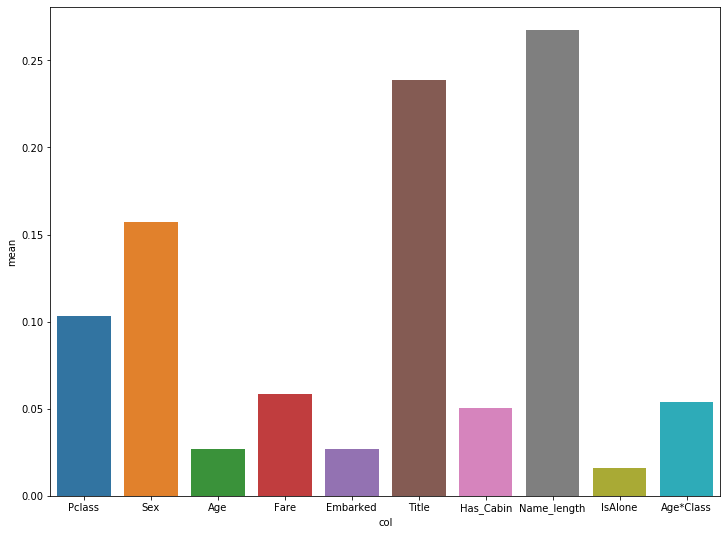

In [327]:
plt.subplots(figsize=(12,9))
sns.barplot(x='col',y='mean',data=feature_df)

In [342]:
base_prediction_train=pd.DataFrame({'RandomForest':rf_oof_train.ravel(),'ExtraTrees':et_oof_train.ravel(),'AdaBoost':ada_oof_train.ravel(),'GradientBoost':gb_oof_train.ravel()})

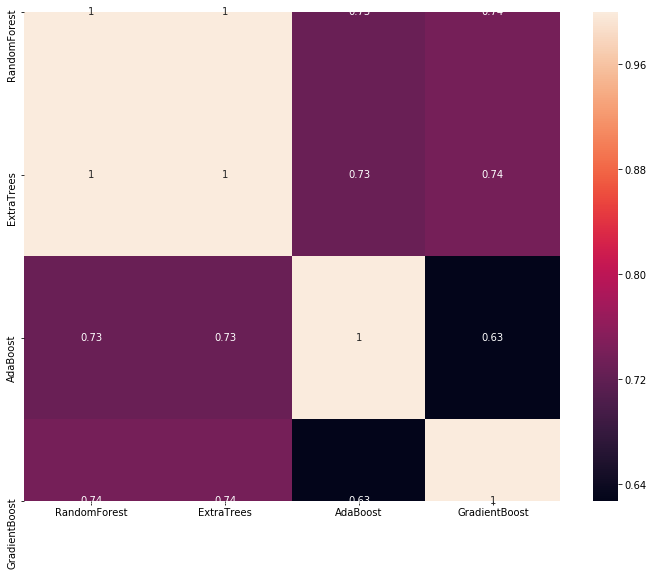

In [345]:
plt.subplots(figsize=(12,9))
sns.heatmap(base_prediction_train.corr(),annot=True)

In [366]:
X_train_level2=np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
X_test_level2=np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test),axis=1)

In [364]:
xgb=XGBClassifier(n_estimators=2000,max_depth=4,min_child_weight=2,gamma=0.9,
                 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',
                 nthread=-1,scale_pos_weight=1)

xgb.fit(X_train_level2,y_train)
y_pred=xgb.predict(X_test_level2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.9,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=2000, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [372]:
stackingSubmission=pd.DataFrame({'PassengerId':test_df.PassengerId,'Prediction':y_pred})